In [1]:
# dependencies

import numpy as np
import pandas as pd

import xfx.glm.binomial
import xfx.misc.plot

In [2]:
# helper functions

def package_samples(samples, factor_names):

    rfx_samples, prec_samples = zip(*samples)
    rfx_samples = [np.array(samples_) for samples_ in zip(*rfx_samples)]
    prec_samples = np.array(prec_samples)
    return package_rfx_samples(rfx_samples, ['_const'] + factor_names), package_prec_samples(prec_samples, factor_names)

def package_rfx_samples(rfx_samples, factor_names):

    dfs = []
    for samples_, factor_name in zip(rfx_samples, factor_names):
        df_ = pd.DataFrame(samples_.T)
        df_.index = df_.index.rename('level')
        df_.columns = df_.columns.rename('iter')
        df_['factor'] = factor_name
        dfs.append(df_)
    df = pd.concat(dfs).reset_index().set_index(['factor', 'level'])
    return df

def package_prec_samples(prec_samples, factor_names):

    df = pd.DataFrame(prec_samples.T, index=factor_names)
    df.index = df.index.rename('factor')
    df.columns = df.columns.rename('iter')
    return df

In [3]:
# select predictors

factor_names = ['stt', 'reg', 'eth', 'inc', 'age']

In [4]:
# configure algorithm (hyperprior on the random effect prior precision is Wishart(prior_pseudo_tau, prior_guess_tau / prior_pseudo_tau))

n_samples = 1000
n_warmup = 100
prior_pseudo_tau = np.ones(len(factor_names))
prior_guess_tau = np.ones(len(factor_names))
seed = 0

In [5]:
# create inputs

gg = pd.read_csv('demos/data/gg.csv')
n_true = gg.success
n_trials = gg.success + gg.failure
indices = gg.loc[:, factor_names].apply(lambda x: x.astype('category').cat.codes)
n_levels = indices.max(0).values + 1
rng = np.random.default_rng(seed)

In [6]:
# sample

sampler = xfx.glm.binomial.sample_posterior(n_true.values, n_trials.values, n_levels, indices.values, prior_pseudo_tau, prior_guess_tau, ome=rng)
samples = [next(sampler) for _ in range(n_samples + n_warmup)][n_warmup:]

In [7]:
# reformat samples for plotting

rfx_samples, prec_samples = package_samples(samples, factor_names)

In [8]:
# random effects samples

rfx_samples.iloc[:5, :5]

iter                 0         1         2         3         4
factor level                                                  
_const 0      0.873229  0.142777  0.647299  0.163302  0.051481
stt    0     -0.176918 -0.248385 -0.217005 -0.170588 -0.358864
       1      0.344272  0.361102  0.349109  0.343902  0.241888
       2      0.075794  0.204951  0.289857  0.169700  0.122528
       3     -0.361116 -0.338015 -0.422806 -0.399217 -0.468396

In [9]:
# prior precision samples

prec_samples.iloc[:5, :5]

iter,0,1,2,3,4
factor,,,,,
stt,13.118829,14.259877,11.285411,10.197885,12.741007
reg,4.674643,2.948398,4.087920,2.385966,2.656293
eth,3.114438,4.051638,4.156006,2.615473,1.942509
inc,1.334932,1.282926,1.481888,3.808803,0.474182
age,3.290122,1.226370,0.612119,1.302549,1.347888


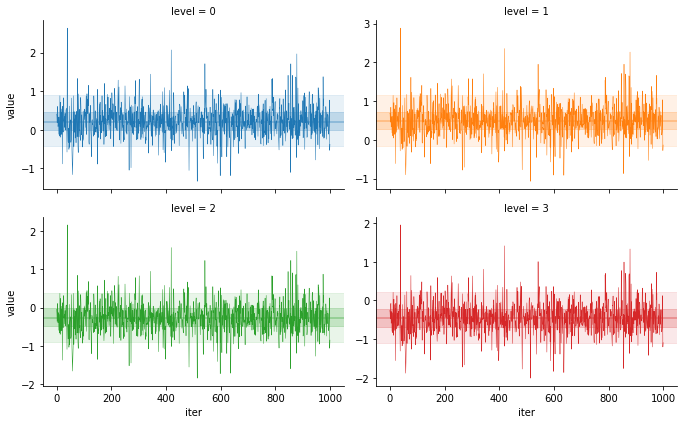

In [10]:
# plot traces for 'eth' random effects, grid and color by level

xfx.misc.plot.plot_traces(rfx_samples.loc['eth'], 'iter', 'level', 'level')

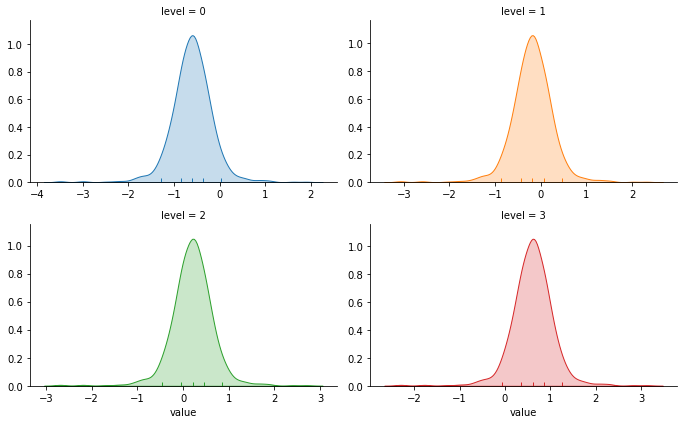

In [11]:
# plot marginals for 'age' random effects, grid and color by level

xfx.misc.plot.plot_marginals(rfx_samples.loc['age'], 'level', 'level')

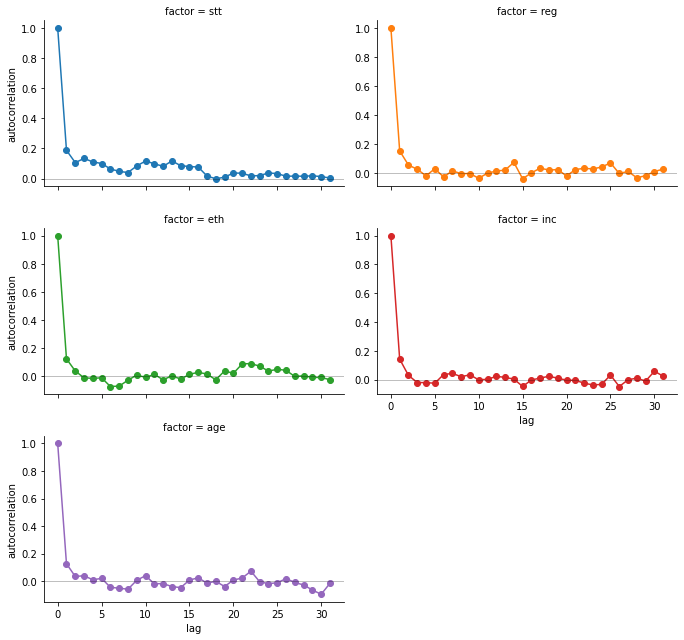

In [12]:
# plot ACFs for prior precisions, grid and color by level

xfx.misc.plot.plot_acf(prec_samples, 'factor', 'factor')